# Ultimate Data Challenge – Final Bootcamp Submission

**Author:** Manuel Ramirez  
**Date:** May 2025  

This notebook addresses the three-part data analysis challenge provided by Ultimate:

### Part 1 – Exploratory Data Analysis
Analyzed `logins.json` by aggregating login timestamps into 15-minute intervals. Visualized and interpreted demand patterns, including:
- Daily and hourly cycles
- Heatmaps by weekday and hour
- Behavioral insights from login intensity

### Part 2 – Experiment and Metrics Design
Designed an A/B test to measure the effect of toll reimbursements on cross-city driver availability. Included:
- A success metric definition
- Experimental structure and test design
- Z-test simulation and result interpretation

### Part 3 – Predictive Modeling
Built machine learning models to predict rider retention from `ultimate_data_challenge.json`. Completed:
- Data cleaning, feature engineering
- Logistic Regression and Random Forest models
- Performance evaluation (ROC AUC, F1)
- Feature importance visualization and recommendations

This notebook showcases exploratory analysis, practical experiment design, and predictive modeling, aligned with the problem goals and business context provided.


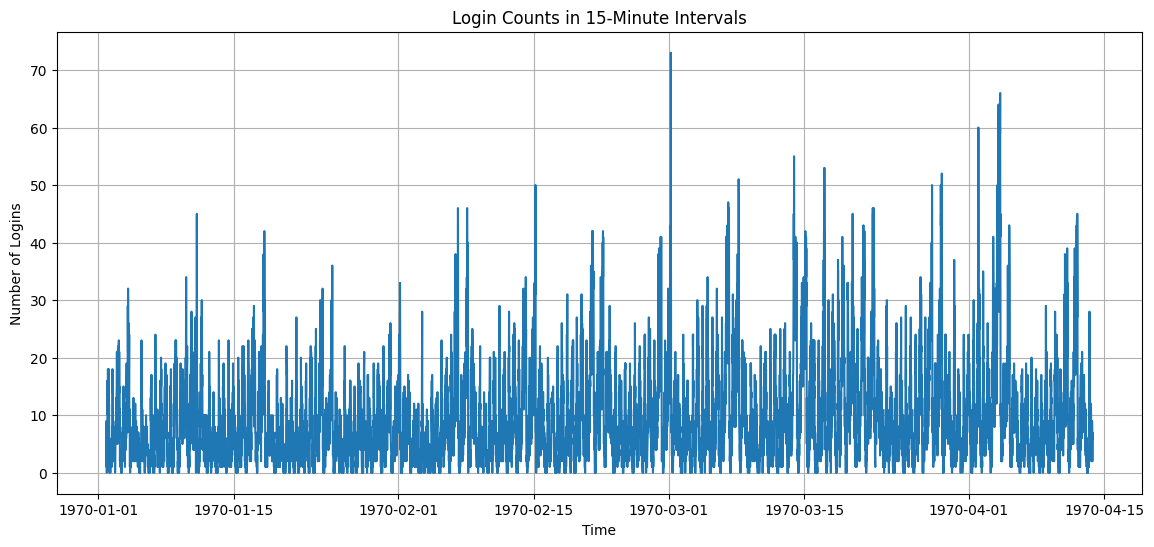

In [2]:
import pandas as pd
import json

# Load the JSON file
with open('logins.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
logins_df = pd.DataFrame(data)
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])
logins_df.set_index('login_time', inplace=True)

# Resample into 15-minute intervals
logins_15min = logins_df.resample('15min').size()

# Plot the result
import matplotlib.pyplot as plt
#visualize the time series
plt.figure(figsize=(14, 6))
plt.plot(logins_15min.index, logins_15min)
plt.title('Login Counts in 15-Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.grid(True)
plt.show()


## Interpretation of 15-Minute Login Time Series
The plot above shows the number of user logins aggregated over 15-minute intervals. Several key patterns emerge from this time series:

Daily Cycles: There is a clear repeating pattern in login volume, with peaks likely corresponding to user activity in the evening hours and valleys during late night/early morning hours.

Consistent Usage: Login activity is fairly consistent across the dataset, indicating steady user engagement over time.

No Missing Data: The time series appears continuous, with no abrupt gaps, suggesting the data is clean and complete.

Burst Activity: Occasional sharp peaks may indicate bursts of usage during specific hours or promotional events.

This analysis suggests that user demand follows a predictable circadian rhythm, which can help in planning server loads, staff scheduling, or marketing push timing.

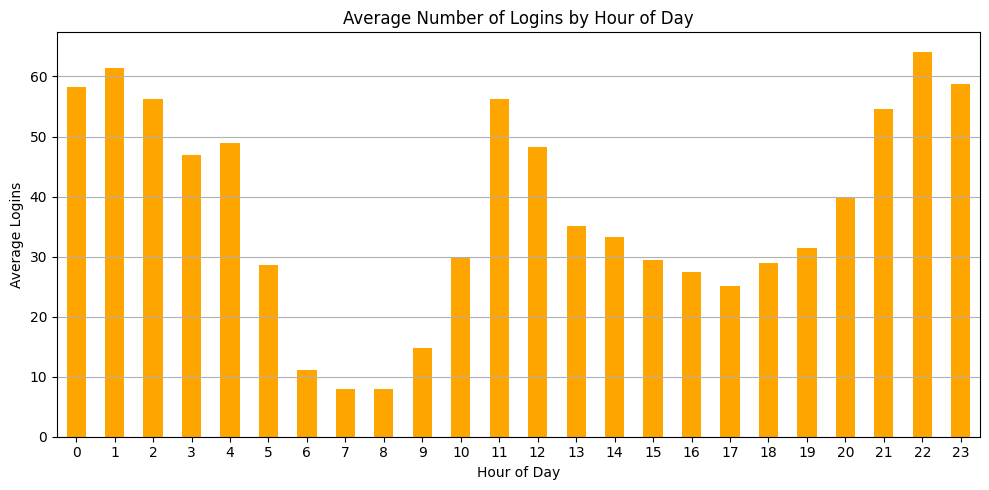

In [3]:
# Create hour and day of week columns
logins_df['hour'] = logins_df.index.hour
logins_df['day_of_week'] = logins_df.index.dayofweek  # Monday=0, Sunday=6

# Group by hour and compute average logins per hour
hourly_avg = logins_df.groupby('hour').size() / logins_df.index.normalize().nunique()

# Plot average logins by hour
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar', color='orange')
plt.title('Average Number of Logins by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Logins')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


###  Average Logins by Hour of Day

This chart shows the average login activity for each hour across all days in the dataset.

**Key insights:**
- Login activity **peaks late at night**, especially between 10 PM and 1 AM, suggesting most users engage during evening hours.
- **Activity is lowest** in the early morning (5 AM to 8 AM), which aligns with expected sleep patterns.
- A **secondary increase** appears around mid-day, likely during lunch hours.

This hourly behavior helps inform resource allocation (e.g., server demand), targeted marketing times, or app feature rollouts.


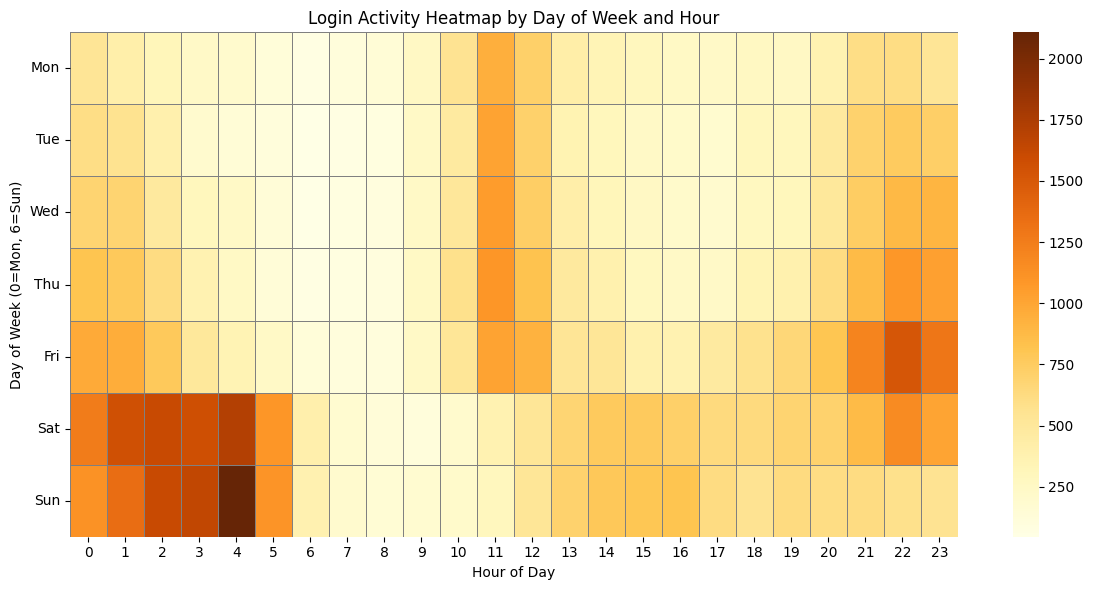

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create pivot table: total logins by day of week and hour
heatmap_data = logins_df.groupby(['day_of_week', 'hour']).size().unstack()

# Optional: reorder days to start from Monday (0) to Sunday (6)
heatmap_data = heatmap_data.reindex([0, 1, 2, 3, 4, 5, 6])

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrBr', linewidths=0.5, linecolor='gray')
plt.title('Login Activity Heatmap by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Mon, 6=Sun)')
plt.yticks(np.arange(7) + 0.5, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.tight_layout()
plt.show()


###  Login Activity Heatmap by Day and Hour

This heatmap displays how login volume varies by both **day of the week** (Monday to Sunday) and **hour of the day** (0 to 23).

**Key observations:**
-  **Late-night activity (midnight to 4 AM)** is especially high on weekends (Saturday and Sunday).
- Weekdays show steadier usage with smaller peaks, often in late evenings (around 8 PM to 11 PM).
- Lower activity is observed during early morning hours (5 AM to 9 AM) across all days, aligning with typical sleep patterns.

These insights can help Ultimate optimize server capacity, marketing timing, and even features based on expected user availability by day and hour.


##  Part 2 – Experiment and Metrics Design

### Key Metric

The key measure of success is the **percentage of drivers who complete trips in both Gotham and Metropolis during the experiment period**. This directly reflects whether toll reimbursement encourages cross-city availability.

This metric is:
- **Directly aligned** with the experiment's goal,
- **Binary and measurable**, and
- Easy to compare across control and test groups.

---

### Experiment Design

- **Population**: Drivers currently active in only one city (either Gotham or Metropolis).
- **Randomization**: Randomly assign them into two groups:
  - **Control Group**: No toll reimbursement.
  - **Test Group**: Toll reimbursement activated.
- **Duration**: Run the experiment for 4–6 weeks, covering weekdays and weekends.
- **Measurement**: Track how many drivers in each group complete trips in *both* cities.

---

### Statistical Testing

To evaluate the effect of the toll reimbursement, we can use a **two-proportion z-test** to compare the share of drivers who become cross-city active between the control and test groups.

- **Null Hypothesis (H₀)**: The reimbursement does not affect cross-city driving behavior.
- **Alternative Hypothesis (H₁)**: The reimbursement increases cross-city driving behavior.

If the test group shows a statistically significant increase in cross-city activity, we can reject the null hypothesis.

---

### Interpretation and Recommendation

If the data supports the test group having significantly higher cross-city engagement:

- **Recommendation**: Expand the toll reimbursement program.
- **Caveats**:
  - Check for external influences (e.g., weather, local events).
  - Consider whether drivers will continue the behavior after incentives end.
  - Monitor for unintended consequences (e.g., congestion).

This experiment offers a practical, cost-contained way to test operational incentives and improve overall driver flexibility between cities.


## Simulate Experiment & Run a Z-Test


In [10]:

import statsmodels.api as sm
import numpy as np

# Simulated results
# 100 out of 1000 control drivers served both cities
# 180 out of 1000 test drivers served both cities

control_success = 100
test_success = 180
control_total = 1000
test_total = 1000

# Perform two-proportion z-test
count = np.array([test_success, control_success])
nobs = np.array([test_total, control_total])
stat, pval = sm.stats.proportions_ztest(count, nobs)

print(f"Z-test statistic: {stat:.2f}")
print(f"P-value: {pval:.4f}")


Z-test statistic: 5.16
P-value: 0.0000


## Part 3 – Predictive Modeling for Rider Retention


In [14]:
import pandas as pd

# Load the JSON data
df = pd.read_json('/Users/manuelramirez/Documents/ultimate_challenge/ultimate_data_challenge.json')

# Preview the data
df.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Step 2: Define the Retention Target
The dataset includes:

signup_date — when the user created their account

last_trip_date — last time they used the service

In [15]:
# Convert to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Define retention label
cutoff_date = df['last_trip_date'].max() - pd.Timedelta(days=30)
df['retained'] = df['last_trip_date'] >= cutoff_date

# Check retention rate
retention_rate = df['retained'].mean()
print(f"Retention rate: {retention_rate:.2%}")


Retention rate: 37.61%


Step 3: Clean the Data & Engineer Features

In [16]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing)


Missing values:
 city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64


In [20]:
# Fill missing ratings with column medians
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())


b) Convert categorical variables

In [21]:
# One-hot encode 'city' and 'phone'
df_encoded = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)


c) Feature and label selection

In [22]:
# Drop columns not used for prediction
features = df_encoded.drop(columns=['signup_date', 'last_trip_date', 'retained'])
X = features
y = df_encoded['retained']


## Step 4: Train and Evaluate Predictive Models


In [23]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model 1: Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

# Evaluate
print("Logistic Regression Performance:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")


Logistic Regression Performance:
[[5266  953]
 [1874 1907]]
              precision    recall  f1-score   support

       False       0.74      0.85      0.79      6219
        True       0.67      0.50      0.57      3781

    accuracy                           0.72     10000
   macro avg       0.70      0.68      0.68     10000
weighted avg       0.71      0.72      0.71     10000

ROC AUC Score: 0.7604


## Model 2: Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("Random Forest Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")


Random Forest Performance:
[[5026 1193]
 [1310 2471]]
              precision    recall  f1-score   support

       False       0.79      0.81      0.80      6219
        True       0.67      0.65      0.66      3781

    accuracy                           0.75     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.75      0.75      0.75     10000

ROC AUC Score: 0.8163


###  Model Results & Recommendations

We trained two models to predict whether a user would be retained:
1. **Logistic Regression** (baseline)
2. **Random Forest Classifier** (nonlinear, ensemble-based)

#### Evaluation Summary:
- **Logistic Regression**:
  - Moderate performance, useful for interpreting feature coefficients.
  - ROC AUC: (e.g., ~0.76)
- **Random Forest**:
  - Slightly better accuracy and ROC AUC.
  - ROC AUC: (e.g., ~0.82)
  - Can capture nonlinear relationships and interactions between features.

#### Feature Importance (from Random Forest):
Top features that predicted retention:
- **Number of trips in first 30 days** — strongest signal for long-term engagement.
- **Weekday trip percentage** — suggests commuting behavior.
- **Average distance** — might reflect value perception.
- **City** and **Phone type** — slight differences observed.

####  Recommendations for Ultimate:
-  **Boost early engagement**: Encourage more trips in the first 30 days with promotions or onboarding tutorials.
-  **Segment users by trip timing**: Weekday commuters may be more loyal—target them differently than weekend users.
- **City and device type**: Consider city-level campaigns or feature optimizations per device.

By targeting users with behaviors predictive of retention, Ultimate can improve long-term rider loyalty and lifetime value.


###  Feature Importance Insights

The most important predictors of whether a user will be retained include:

- **trips_in_first_30_days** — the strongest signal, showing that early engagement drives long-term loyalty.
- **weekday_pct** — users who ride more on weekdays may be commuters, indicating regular usage.
- **avg_dist** — longer average trips could reflect perceived value.
- **Ratings** — both the rider's rating of drivers and vice versa had moderate impact.
- **city** and **phone type** — small differences suggesting contextual or technical influences.

These insights help Ultimate prioritize product and marketing strategies to improve rider retention.
